In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
%matplotlib inline

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("data\labeled_data.csv")
df.drop(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


##### label 
0 - hate speech
1 - offensive  language
2 - neither

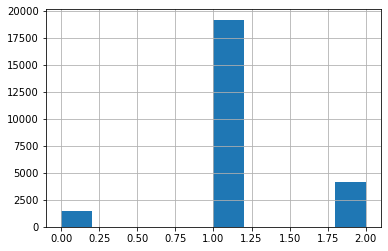

In [5]:
df['class'].hist()

##### i will try to balance my data

In [6]:
df = df.rename(index=str, columns={"class": "label", "tweet": "tweet"})
df.head()

,label,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
X = df.tweet
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)
print(Y)
Y = to_categorical(Y)
#Y = Y.reshape(-1,1)
print(Y)

[2 1 1 ... 1 1 2]
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


##### spliting data Train / Test  85:15

In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)


In [14]:
max_words = 1000
max_len = 260
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

### Defining Model

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(3,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [19]:
model = RNN()
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.01),metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 260)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 260, 50)           50000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 3)                 771 

In [36]:
df['label'].value_counts()

1    19190
2     4163
0     1430
Name: label, dtype: int64

In [38]:
class_weight = {0: 50.,
                1: 1.,
                2: 20.}

In [39]:
b=model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10, class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
165/165 [==============================] - 69s 389ms/step - loss: 5.3569 - accuracy: 0.2718
Epoch 2/10
165/165 [==============================] - 66s 401ms/step - loss: 2.8713 - accuracy: 0.6360
Epoch 3/10
165/165 [==============================] - 80s 483ms/step - loss: 2.5480 - accuracy: 0.6654
Epoch 4/10
165/165 [==============================] - 74s 448ms/step - loss: 2.2483 - accuracy: 0.6800
Epoch 5/10
165/165 [==============================] - 59s 357ms/step - loss: 1.9900 - accuracy: 0.6997
Epoch 6/10
165/165 [==============================] - 55s 334ms/step - loss: 1.7751 - accuracy: 0.7053
Epoch 7/10
165/165 [==============================] - 55s 331ms/step - loss: 1.4469 - accuracy: 0.7505
Epoch 8/10
165/165 [==============================] - 57s 344ms/step - loss: 1.4040 - accuracy: 0.7583
Epoch 9/10
165/165 [==================

#### APPLYING MODEL IN TESTING

In [53]:
#tok = Tokenizer(num_words=max_words)
#tok.fit_on_texts(X_test)
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [54]:
accr = model.evaluate(test_sequences_matrix,Y_test)


117/117 [==============================] - 5s 43ms/step - loss: 0.9011 - accuracy: 0.7380


In [55]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


Test set
  Loss: 0.901
  Accuracy: 0.738


In [56]:
y_preds = model.predict(test_sequences_matrix)


In [59]:
Y_t = []
for i in Y_test:
  Y_t.append(np.argmax(i))
  
#print(Y_t)


Y_p = []

for i in y_preds:
  Y_p.append(np.argmax(i))
  
#print(Y_p)

In [60]:
report = classification_report( Y_t, Y_p )
print(report)

              precision    recall  f1-score   support

           0       0.18      0.72      0.28       211
           1       0.98      0.70      0.82      2877
           2       0.72      0.92      0.81       630

    accuracy                           0.74      3718
   macro avg       0.63      0.78      0.64      3718
weighted avg       0.89      0.74      0.78      3718



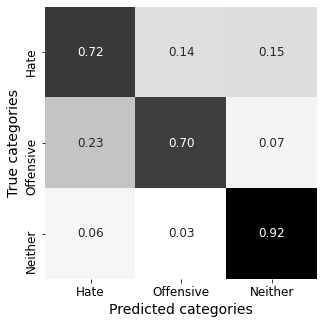

In [46]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_t,Y_p)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [47]:
test=pd.read_csv(r"C:\Users\3alaa\Desktop\Untitled Folder\data\reddit.csv")
#test=test.drop(columns=['0','1467810369','NO_QUERY','_TheSpecialOne_','Mon Apr 06 22:19:45 PDT 2009'])
#test=test.rename(columns={"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D":"text"})

In [48]:
test=test.drop(columns=['id','hate_speech_idx','response'])

In [84]:
data={'text':['']}
test=pd.DataFrame(data)

In [85]:
r=test.head(20)
b=r["text"]

In [86]:
ts = tok.texts_to_sequences(b)
tss = sequence.pad_sequences(ts,maxlen=max_len)
pred=model.predict(tss)
Y_t = []
for i in pred:
  Y_t.append(np.argmax(i))
  
print(Y_t)

[0]


limitation ( cursted words or symbols in words
)